# Step 5 - Model Training

This notebook has the following goals:

- Split the data into training and test sets, ensuring the test set reflects the current year's data.

- Train the models below using the original raw data:
    - K-Nearest Neighbors (KNN) Classifier
    - Random Forest

- Retrain and reevaluate the models using modified data with PCA and SMOTE techniques.

- Assess the impact of hyperparameter optimization (HPO) in both conditions.

- Define the final model solution and address the two main project questions.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## 5.0 - Load the Data

In [3]:
previous_scaled = pd.read_csv('../data/05_previous_years_scaled.csv')
present_scaled = pd.read_csv('../data/06_present_year_scaled.csv')

## 5.1 - Model Centric Approach

Apply the ML models on the original raw data without use any PCA or SMOTE technique at first.

### 5.1.1 - Train and Test Split

Since we have the instruction fir the executive board that:

> The final results that will be presented need to be evaluated against air_system_present_year.csv. 

The *train* and *test* split is easily defined as:

- **Training Data:** We will use the `air_system_previous_years.csv` to train the machine learning models.

- **Testing Data:** We will evaluate the trained models using `air_system_present_year.csv`.

In [4]:
# Separate target and features for training data
y_train = previous_scaled['class']
X_train = previous_scaled.drop('class', axis=1)

# Separate target and features for test data
y_test = present_scaled['class']
X_test = present_scaled.drop('class', axis=1)

print("Training features shape:", X_train.shape)
print("Training target shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test target shape:", y_test.shape)

Training features shape: (60000, 170)
Training target shape: (60000,)
Test features shape: (16000, 170)
Test target shape: (16000,)


### 5.1.2 - KNN Classifier

In [5]:
# Fit the data on the classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)

# Evaluate the performance
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.86      0.52      0.65       375

    accuracy                           0.99     16000
   macro avg       0.93      0.76      0.82     16000
weighted avg       0.99      0.99      0.99     16000



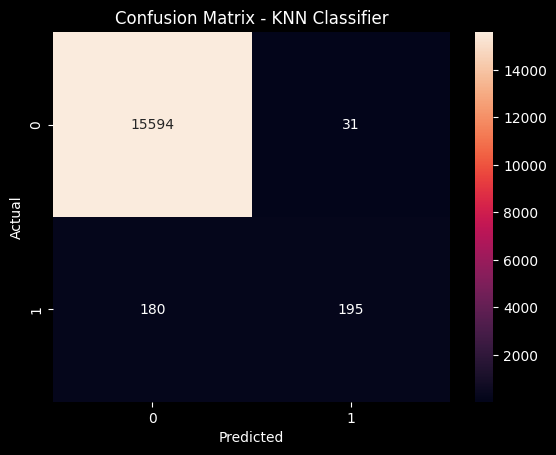

In [6]:
# Calculate the confusion matrix
def confmatrix(y_test, y_pred, title):

    """
    Calculates and visualizes the confusion matrix for the given true and predicted labels.

    """
    
    cm = confusion_matrix(y_test, y_pred)

    # Get unique class labels from y_test
    classes = np.unique(y_test)

    tn, fp, fn, tp = cm.ravel()


    # Create a heatmap using seaborn
    plt.style.use("dark_background")
    sns.heatmap(cm, annot=True, fmt="d", cmap="rocket", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

    return tn, fp, fn, tp 

tn, fp, fn, tp = confmatrix(y_test, y_pred_knn, title = "Confusion Matrix - KNN Classifier")

**Performance Analysis**

- **Recall:** The recall for the minority class (1) is quite low (0.52), indicating that the model is missing many of the positive cases.

### 5.1.3 - Random Forest

In [39]:
# Fit the data on the classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate the performance
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15625
           1       0.96      0.64      0.77       375

    accuracy                           0.99     16000
   macro avg       0.98      0.82      0.88     16000
weighted avg       0.99      0.99      0.99     16000



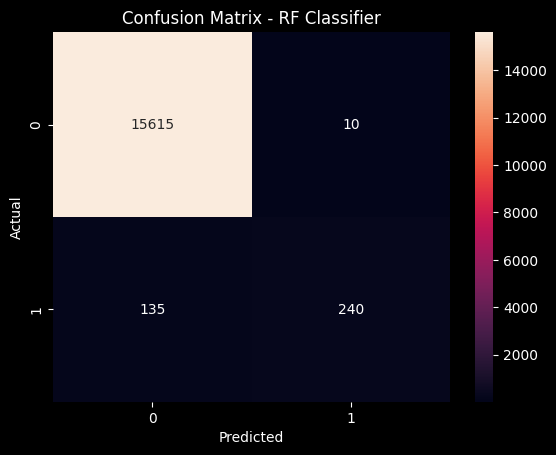

In [40]:
tn, fp, fn, tp = confmatrix(y_test, y_pred_rf, title = "Confusion Matrix - RF Classifier")

**Performance Analysis**

- **Recall:** The recall for the minority class (1) is quite low (0.64), indicating that the model is missing many of the positive cases.
- **Accuracy:** Overall accuracy is high (0.99), but this can be misleading in cases of class imbalance.

This is a tipycal problem of a imbalanced dataset, the first solution is to address class imbalance and perform the feature selection:

- **Resampling Techniques:**
    - **Oversampling:** Use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic samples for the minority class.
    - **Undersampling:** Reduce the number of samples in the majority class to balance the class distribution.

- **Dimensionality Reduction:** Reduce the number of training and test feature using PCA method.

Before this, we also perform a basic HPO on the RF Classifier to visualize that a direct Model Centric approach will not be enough:

### 5.1.4 - Hyperparameter Tunning

Perform extensive hyperparameter tuning using techniques like Grid Search or Random Search to find the optimal settings for the models.

In [28]:
# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(20, 200),       # Number of trees in the forest
    'max_depth': randint(1, 40),            # Maximum depth of each tree
    'min_samples_split': randint(2, 20),    # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),     # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]              # Whether bootstrap samples are used when building trees
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier()

# Set up RandomizedSearchCV
rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,                       # Number of different combinations to try
    cv=5,                           # Number of cross-validation folds
    verbose=2,                      # Verbosity level
    random_state=42,                # For reproducibility
    n_jobs=-1                       # Use all available cores
)

# Fit RandomizedSearchCV to the training data
rand_search.fit(X_train, y_train)
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:', rand_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time=  48.1s
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time=  48.1s
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time=  49.4s
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time=  49.6s
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time=  50.3s
[CV] END bootstrap=True, max_depth=21, min_samples_leaf=7, min_samples_split=12, n_estimators=107; total time=  58.6s
[CV] END bootstrap=True, max_depth=21, min_samples_leaf=7, min_samples_split=12, n_estimators=107; total time=  58.5s
[CV] END bootstrap=True, max_depth=21, min_samples_leaf=7, min_samples_split=12, n_estimators=107; total time= 1.0min
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1

In [ ]:
# Generate predictions with the best model
y_pred_best_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.92      0.62      0.75       375

    accuracy                           0.99     16000
   macro avg       0.96      0.81      0.87     16000
weighted avg       0.99      0.99      0.99     16000



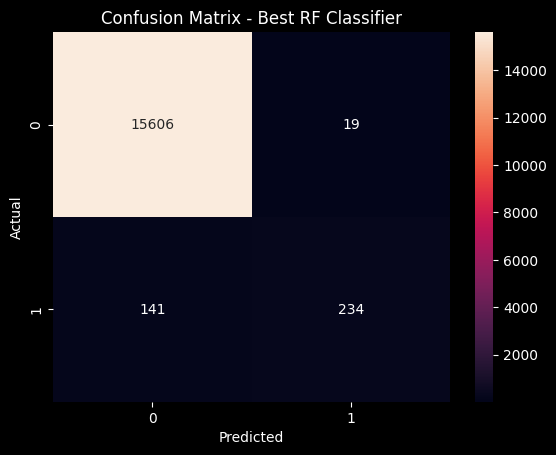

In [ ]:
tn, fp, fn, tp = confmatrix(y_test, y_pred_best_rf, title = "Confusion Matrix - Best RF Classifier")

Note that even with the use of hyperparameter optimization (HPO) techniques, the model still shows poor performance with the current quality of the dataset.

Based on this, we will now adopt a data-centric approach.

## 5.2 - Data Centric Approach

Now, in the second part of this notebook, we will apply the models after performing some data-centric analyses, such as addressing class imbalance and performing dimensionality reduction.

The goal here is to identify the impact of data transformation on the ML models and establish a clear path to optimize the results.

Here, we will apply only the Random Forest models since was the top performing before.

### 5.2.1 - Impact of the SMOTE Technique:

In [99]:
previous_SMOTEd = pd.read_csv('../data/07_previous_years_SMOTEd.csv')
present_data = pd.read_csv('../data/06_present_year_scaled.csv')

# Separate target and features for training data
y_train_SMOTEd = previous_SMOTEd['class']
X_train_SMOTEd = previous_SMOTEd.drop('class', axis=1)

# Separate target and features for test data
y_test = present_data['class']
X_test = present_data.drop('class', axis=1)

print("Training features shape after SMOTE:", X_train_SMOTEd.shape)
print("Training features shape after SMOTE:", y_train_SMOTEd.shape)
print("Test features shape:", X_test.shape)
print("Test target shape:", y_test.shape)

Training features shape after SMOTE: (118000, 170)
Training features shape after SMOTE: (118000,)
Test features shape: (16000, 170)
Test target shape: (16000,)


In [100]:
# Fit the data on the classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_SMOTEd, y_train_SMOTEd)

# Predict
y_pred_SMOTEd_rf = rf.predict(X_test)

# Evaluate the performance
print(classification_report(y_test, y_pred_SMOTEd_rf))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15625
           1       0.61      0.86      0.71       375

    accuracy                           0.98     16000
   macro avg       0.80      0.92      0.85     16000
weighted avg       0.99      0.98      0.99     16000



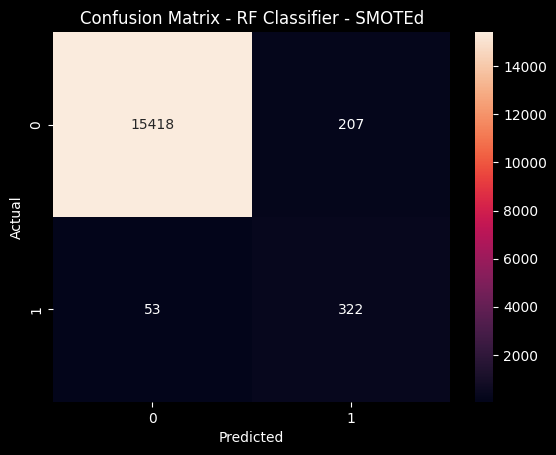

In [101]:
tn, fp, fn, tp = confmatrix(y_test, y_pred_SMOTEd_rf, title = "Confusion Matrix - RF Classifier - SMOTEd")

**Finantial impact of this model:**

In [102]:
cost_SMOTEd = int(fn)*500 + int(fp)*10 + int(tp)*25
print(f"This would generate a cost reduction of: ${37000 - cost_SMOTEd} USD ")

This would generate a cost reduction of: $380 USD 


### 5.2.2 - Impact of the SMOTE and PCA Technique:

In [103]:
previous_PCA = pd.read_csv('../data/08_previous_years_PCA.csv')
present_PCA = pd.read_csv('../data/09_previous_years_PCA.csv')

# Separate target and features for training data
y_train_PCA = previous_PCA['class']
X_train_PCA = previous_PCA.drop('class', axis=1)

# Separate target and features for test data
y_test_PCA = present_PCA['class']
X_test_PCA = present_PCA.drop('class', axis=1)

print("Training features shape after SMOTE and PCA:", X_train_PCA.shape)
print("Training features shape after SMOTE and PCA", y_train_PCA.shape)
print("Test features shape after PCA:", X_test_PCA.shape)
print("Test target shape after PCA:", y_test_PCA.shape)


Training features shape after SMOTE and PCA: (118000, 2)
Training features shape after SMOTE and PCA (118000,)
Test features shape after PCA: (16000, 2)
Test target shape after PCA: (16000,)


In [104]:
# Fit the data on the classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_PCA, y_train_PCA)

# Predict
y_pred_PCA_rf = rf.predict(X_test_PCA)

# Evaluate the performance
print(classification_report(y_test_PCA, y_pred_PCA_rf))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.90      0.41       375

    accuracy                           0.94     16000
   macro avg       0.63      0.92      0.69     16000
weighted avg       0.98      0.94      0.96     16000



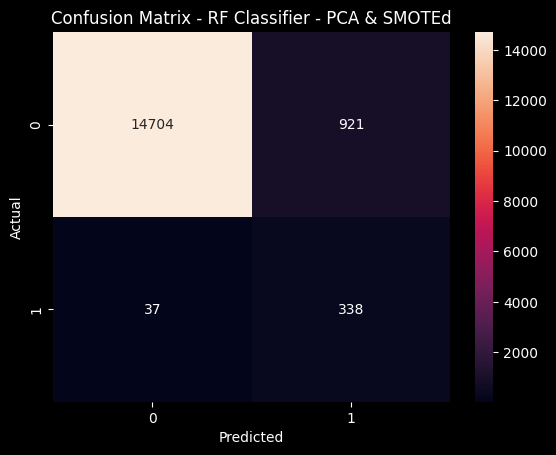

In [105]:
tn, fp, fn, tp = confmatrix(y_test_PCA, y_pred_PCA_rf, title = "Confusion Matrix - RF Classifier - PCA & SMOTEd")

**Finantial impact of this model:**

In [107]:
cost_PCA_SMOTEd = int(fn)*500 + int(fp)*10 + int(tp)*25
print(f"This would generate a cost reduction of: ${37000 - cost_PCA_SMOTEd} USD ")

This would generate a cost reduction of: $840 USD 


### 5.2.3 - Impact of the HPO & SMOTE Techniques:

In [77]:
# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(20, 200),       # Number of trees in the forest
    'max_depth': randint(1, 40),            # Maximum depth of each tree
    'min_samples_split': randint(2, 20),    # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),     # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]              # Whether bootstrap samples are used when building trees
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier()

# Set up RandomizedSearchCV
rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,                       # Number of different combinations to try
    cv=5,                           # Number of cross-validation folds
    verbose=2,                      # Verbosity level
    random_state=42,                # For reproducibility
    n_jobs=-1                       # Use all available cores
)

# Fit RandomizedSearchCV to the training data
rand_search.fit(X_train_SMOTEd, y_train_SMOTEd)
best_rf_SMOTEd = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:', rand_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time= 1.9min
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time= 1.9min
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time= 1.9min
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time= 1.9min
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=15, min_samples_split=12, n_estimators=91; total time= 1.9min
[CV] END bootstrap=True, max_depth=21, min_samples_leaf=7, min_samples_split=12, n_estimators=107; total time= 2.2min
[CV] END bootstrap=True, max_depth=21, min_samples_leaf=7, min_samples_split=12, n_estimators=107; total time= 2.2min
[CV] END bootstrap=True, max_depth=21, min_samples_leaf=7, min_samples_split=12, n_estimators=107; total time= 2.

In [108]:
# Generate predictions with the best model
y_pred_best_rf_SMOTEd = best_rf_SMOTEd.predict(X_test)
print(classification_report(y_test, y_pred_best_rf_SMOTEd))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.58      0.89      0.71       375

    accuracy                           0.98     16000
   macro avg       0.79      0.94      0.85     16000
weighted avg       0.99      0.98      0.98     16000



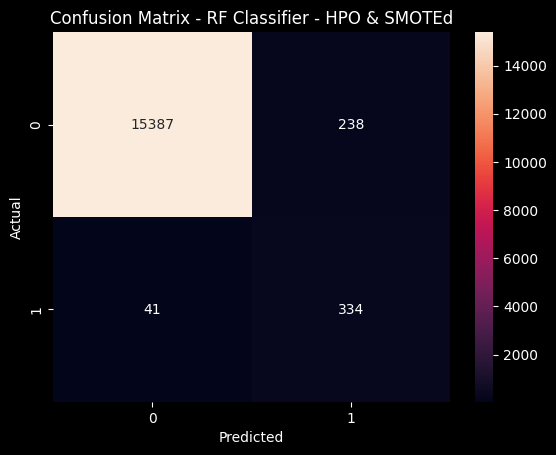

In [109]:
tn, fp, fn, tp = confmatrix(y_test, y_pred_best_rf_SMOTEd, title = "Confusion Matrix - RF Classifier - HPO & SMOTEd")

**Finantial impact of this model:**

In [ ]:
cost_HPO_SMOTEd = int(fn)*500 + int(fp)*10 + int(tp)*25
print(f"This model would generate a cost reduction of USD ${37000 - cost_HPO_SMOTEd}")

This model would generate a cost reduction of USD $5770


This address the question:

> Can we reduce our expenses with this type of maintenance using AI techniques?

**ANSWER:** Yes, we can! In a basic proof of concepto we already achieved $5770 on savings.

### Model Selection Conclusion:

The Random Forest model with hyperparameter optimization (HPO) using random search and SMOTE achieved the best performance, with a precision of `0.58` and recall of `0.89`, which leads to a Macro F1-Score of `0.85`.

When we translate this to business metrics, this results represents a cost reduction of `$5770` in the maintenance of the trucks.

So, the selected model would be the **HPO SMOTEd RandomForest**!

## 5.3 - Feature Importance From the Selected Model

Based on the Random Forest Classifier trained above, we will identify the most important features of the dataset that contribute to predicting failures.

- **Top 10 features for failure in the trucks**

In [ ]:
# Extract feature importances from the best Random Forest model
importances = best_rf_SMOTEd.feature_importances_

# Create and # sort the DataFrame by importance in descending order
feature_importances = pd.DataFrame({'feature': X_train_SMOTEd.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False).head(10)
feature_importances

,feature,importance
96,ck_000,0.105955
142,dn_000,0.069442
0,aa_000,0.061423
80,bt_000,0.053556
24,ap_000,0.052723
82,bv_000,0.039032
62,bb_000,0.038195
94,ci_000,0.034631
25,aq_000,0.031949
17,ai_000,0.026753


This is directly related to the business question: 

>"Can you present the main factors that indicate a possible failure in this system?"*

**ANSWER:** Yes, I can! Above are the top 10 most relevant features for failures in the air system according to the top-performing machine learning model.